In [1]:
import os
import bisect
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from rDLSpp import IOfuncs as iof
from rDLSpp import RheoConfig as rconf
from rDLSpp import RheoCorr as rcorr
from rDLSpp import FTrheo as ft
from DSH import SharedFunctions as sf
from pathlib import Path

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('LoadRheoData tutorial started')

INFO:root:LoadRheoData tutorial started


This tutorial explains how to load and analyze oscillatory rheology experiments

In [21]:
froot = r'D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\05_StressCtr'
rheo_protocol = rconf.RheoProtocol(froot, 'Config_Rheo.ini', 'expLog.txt')
print(rheo_protocol)

INFO:root:106 rows read from expLog file D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\05_StressCtr\expLog.txt


<RheoProtocol (223 intervals)>


In [22]:
list_names = rheo_protocol.GetFullFilenames()
#list_names

In [23]:
rheo_explog = rheo_protocol.LoadExpLog()
rheo_explog

,ID,Time,Type,Name,Force,Displacement,Speed,Period,Offset,RelOffset,...,StartedOn,EndedOn,StartPos,EndPos,StartForce,EndForce,Trigger,Active,Axis,StrainControlled
0,1,3.30827,0,01_Relax_000,<err>,1,6.28319,1,0,1,...,0.022551,3.27708,12.1884,12.1883,-0.00274131,0.0172048,0,1,1,1
1,2,6.60322,0,01_Relax_001,<err>,0.794328,4.99091,1,0,1,...,3.32545,6.57073,12.1883,12.1883,0.0152074,0.0138646,0,1,1,1
2,3,9.90406,0,01_Relax_002,<err>,0.630957,3.96442,1,0,1,...,6.61816,9.87216,12.1883,12.1883,0.0127903,0.00872829,0,1,1,1
3,4,13.2693,0,01_Relax_003,<err>,0.501187,3.14905,1,0,1,...,9.92419,13.2384,12.1883,12.1883,0.00862758,0.00426344,0,1,1,1
4,5,16.6098,0,01_Relax_004,<err>,0.398107,2.50138,1,0,1,...,13.2909,16.5777,12.1883,12.1883,0.0037431,-0.00097354,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,38,890.54,0,03_StrainSweep_1Hz_037,<err>,0.0251189,0.157826,1,0,1,...,880.265,890.492,12.9098,12.9099,0.00293741,0.00357524,0,1,1,1
101,39,900.838,0,03_StrainSweep_1Hz_038,<err>,0.0199526,0.125366,1,0,1,...,890.562,900.792,12.9098,12.9098,0.00273598,0.00307169,0,1,1,1
102,40,911.196,0,03_StrainSweep_1Hz_039,<err>,0.0158489,0.0995818,1,0,1,...,900.853,911.142,12.9098,12.9098,0.00320597,0.00342418,0,1,1,1
103,41,921.468,0,03_StrainSweep_1Hz_040,<err>,0.0125893,0.0791006,1,0,1,...,911.218,921.42,12.9098,12.9098,0.00401166,0.00416272,0,1,1,1


In [24]:
rheo_explog.columns

Index(['ID', 'Time', 'Type', 'Name', 'Force', 'Displacement', 'Speed',
       'Period', 'Offset', 'RelOffset', 'Phase', 'Duration', 'StartTime',
       'StartedOn', 'EndedOn', 'StartPos', 'EndPos', 'StartForce', 'EndForce',
       'Trigger', 'Active', 'Axis', 'StrainControlled'],
      dtype='object')

In [25]:
rheo_explog['Duration']

0       3
1       3
2       3
3       3
4       3
       ..
100    10
101    10
102    10
103    10
104    10
Name: Duration, Length: 105, dtype: object

D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\05_StressCtr\02_StressSweepTest_019a.txt


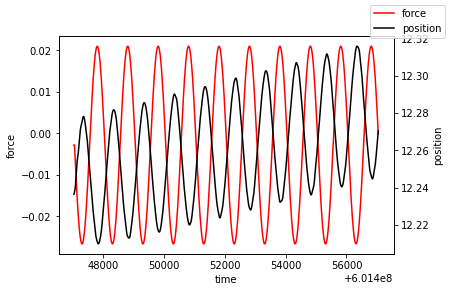

In [31]:
fidx = 40
print(list_names[fidx])
int_time, int_pos, int_force = iof.ReadRheoData(list_names[fidx], usecols=(1, 5, 6), unpack=True)
if int_pos is not None:
    fig, ax = plt.subplots()
    ax.plot(int_time, int_force, 'r-', label='force')
    ax.set_xlabel('time')
    ax.set_ylabel('force')
    ax2 = ax.twinx()
    ax2.plot(int_time, int_pos, 'k-', label='position')
    ax2.set_ylabel('position')
    fig.legend()


Analysis routines

In [2]:
def find_namebase(fpath, ret_suffix=False, rep_len=1):
    cur_fname = os.path.basename(fpath)[:-4]
    suff = ''
    if cur_fname[-4:] in ['_POS', '_NEG']:
        suff = cur_fname[-4-rep_len:]
        cur_fname = cur_fname[:-4]
    else: 
        suff = cur_fname[-rep_len:]
    if ret_suffix:
        return cur_fname[:-rep_len], suff
    else:
        return cur_fname[:-rep_len]

def find_file_params(fname, rep_len=1):
    cur_namebase, suffix = find_namebase(fname, ret_suffix=True, rep_len=rep_len)
    find_params = rheo_explog[rheo_explog['Name'].str.contains(cur_namebase)]
    if len(find_params)==1:
        return find_params.iloc[0]
    elif len(find_params)>0:
        if suffix[-3:] == 'POS':
            return find_params.iloc[0]
        elif suffix[-3:] == 'NEG':
            return find_params.iloc[1]
        else:
            return find_params.iloc[0]
    else:
        logging.debug('find_params ({0}) has len==0'.format(cur_namebase))
        return None

def proc_file(fpath, anal_type='read', anal_params={}):
    find_params = find_file_params(fpath)
    if find_params is not None:
        if int(find_params['Axis'])==1:
            cur_straincol, cur_osrstrain_col = 5, 2
        else:
            cur_straincol, cur_osrstrain_col = 2, 5
        if anal_type in ['read', 'plot', 'flowcurve', 'avgperiod']:
            t, strain, stress = iof.ReadRheoData(fpath, usecols=(1, cur_straincol, 6), unpack=True)
        if anal_type=='count':
            return 1
        elif anal_type=='read':
            return t, strain, stress
        elif anal_type=='plot':
            ax = anal_params['ax']
            if anal_params['plot_type'] == 'time':
                ax[0].plot((t-t[0])/1000-anal_params['t0'], strain, anal_params['fmt'])
                ax[1].plot((t-t[0])/1000-anal_params['t0'], stress, anal_params['fmt'])
            elif anal_params['plot_type'] == 'stressstrain':
                ax.plot(strain, stress, anal_params['fmt'])
            elif anal_params['plot_type'] == 'stressrelax':
                ax.plot((t-t[0])/1000-anal_params['t0'], stress, anal_params['fmt'])
        elif anal_type == 'avgperiod':
            if 'StartIdx' not in anal_params:
                anal_params['StartIdx'] = 0
            if 'EndIdx' not in anal_params:
                anal_params['EndIdx'] = 0
            avg_res = np.empty((anal_params['PeriodIdx'], 3), dtype=float)
            avg_res[:,0] = (t[:anal_params['PeriodIdx']]-t[0])/1000
            for i in range(avg_res.shape[0]):
                avg_res[i,1] = np.mean(strain[i::anal_params['PeriodIdx']])
                avg_res[i,2] = np.mean(stress[i::anal_params['PeriodIdx']])
            return avg_res
        elif anal_type in ['FT', 'OSR']:
            if 'Tres_Step' in anal_params and 'Tres_Nint' not in anal_params:
                anal_params['Tres_Nint'] = 1
            OSR_period, ORS_amp = None, None
            if 'OSRparams' in anal_params:
                if anal_params['OSRparams'] is not None:
                    OSR_period = anal_params['OSRparams']['Period']
                    ORS_amp = anal_params['OSRparams']['Amp']
            tres_res = None
            if anal_type=='FT':
                OSR_period, ORS_amp = np.nan, np.nan
                int_duration = float(find_params['Duration'])
                int_period = float(find_params['Period'])
                if 'nperiods' not in anal_params:
                    anal_params['nperiods'] = int(int_duration/int_period - 2)
                G, opt = ft.FTanalysisRheology(fpath, Period=int_period, AnalyzePeriods=anal_params['nperiods'], 
                                             FreqRecord=None, usecols=(1,cur_straincol,6))
                if 'Tres_Step' in anal_params:
                    tres_res = ft.CalcTimeDependentModuli(fpath, Period=int_period, StepTime=anal_params['Tres_Step'], 
                                                      AnalyzePeriods=anal_params['Tres_Nint'], Duration=int_duration, usecols=(1,cur_straincol,6))
                    
            else:
                t = iof.ReadRheoData(fpath, usecols=(1), unpack=True)
                int_duration = (t[-1]-t[0])/1000
                if OSR_period is not None:
                    if 'nperiods' not in anal_params:
                        anal_params['nperiods'] = int(int_duration/OSR_period - 2)
                    G, opt = ft.FTanalysisRheology(fpath, Period=OSR_period, AnalyzePeriods=anal_params['nperiods'], 
                                                 FreqRecord=None, usecols=(1,cur_osrstrain_col,6))
                    if 'Tres_Step' in anal_params:
                        tres_res = ft.CalcTimeDependentModuli(fpath, Period=OSR_period, StepTime=anal_params['Tres_Step'], 
                                                           AnalyzePeriods=anal_params['Tres_Nint'], Duration=int_duration, usecols=(1,cur_osrstrain_col,6))
                else:
                    opt = None
            if tres_res is not None:
                tres_fpath = sf.AddSuffixToPath(fpath, '_tres' + anal_type)
                np.savetxt(tres_fpath, tres_res, delimiter='\t', header='t[s]\tGp\tGs')
            if opt is not None:
                opt['OSR_Amp'] = ORS_amp
                opt['OSR_Period'] = OSR_period
                opt['Type'] = int(find_params['Type'])
                if opt['Type'] == 0:
                    opt['Amplitude'] = float(find_params['Displacement'])
                else:
                    opt['Amplitude'] = float(find_params['Force'])
                try:
                    opt['Period'] = float(find_params['Period'])
                except:
                    opt['Period'] = np.nan
                try:
                    opt['Offset'] = float(find_params['Offset'])
                except:
                    opt['Offset'] = np.nan
                opt['StartedOn'] = float(find_params['StartedOn'])
            return opt
        elif anal_type=='flowcurve':
            d_range = anal_params['displ_range']
            min_idx = bisect.bisect(np.abs(strain-strain[0]), d_range[0])
            max_idx = bisect.bisect(np.abs(strain-strain[0]), d_range[1])
            if max_idx <= min_idx:
                raise ValueError('Error bisecting strain list (start: {0}, end: {1}) with displacement range {2}'.format(strain[0], strain[1], d_range))
                return None
            else:
                return float(find_params['Speed']), np.mean(stress[min_idx:max_idx])
    else:
        if anal_type=='count':
            return 0
        else:
            return None

def proc_files(fpath_list, filter_type=None, filter_axis=None, filter_name=None, rep_len=1, max_num=None, anal_type='read', anal_params={}):
    res = []
    anal_params = anal_params
    proc_count = 0
    if anal_type=='plot':
        cycle_num = int(proc_files(fpath_list, filter_type=filter_type, filter_axis=filter_axis, anal_type='count', max_num=max_num))
        if cycle_num<=0:
            cycle_num=1
        if 'plot_type' not in anal_params:
            anal_params['plot_type'] = 'time'
        if 't0' not in anal_params:
            anal_params['t0'] = 0.0
        if 'fmt' not in anal_params:
            anal_params['fmt'] = '-'
        fig, ax = plt.subplots()
        ax.set_prop_cycle(color=plt.cm.cool(np.linspace(0,1,cycle_num)))
        if anal_params['plot_type'] == 'time':
            ax2 = ax.twinx()
            ax2.set_prop_cycle(color=plt.cm.summer(np.linspace(0,1,cycle_num)))
            ax.set_xlabel('time [s]')
            ax.set_ylabel('displacement [mm]')
            ax2.set_ylabel('force [N]')
            anal_params['ax'] = [ax, ax2]
        elif anal_params['plot_type'] == 'stressstrain':
            ax.set_xlabel('displacement [mm]')
            ax.set_ylabel('force [N]')
            anal_params['ax'] = ax
        elif anal_params['plot_type'] == 'stressrelax':
            ax.set_xlabel('time [s]')
            ax.set_ylabel('force [N]')
            ax.set_xscale('log')
            anal_params['ax'] = ax
    for i in range(len(fpath_list)):
        cur_fname = fpath_list[i]
        find_params = find_file_params(cur_fname)
        if find_params is None:
            logging.debug('Skipping file {0}/{1}: no match found in parameter table for filename "{2}" (namebase: {3})'.format(i, len(fpath_list), cur_fname, find_namebase(cur_fname, rep_len=rep_len)))
        else:
            do_process = True
            if filter_type is not None:
                do_process = (int(find_params['Type']) == filter_type)
            if do_process and filter_axis is not None:
                do_process = (int(find_params['Axis']) == filter_axis)
            if do_process and filter_name is not None:
                do_process = (filter_name in find_params['Name'])
            if do_process:
                logging.debug('Processing file {0}/{1}, of type {2} (fname: {3})'.format(i, len(fpath_list), find_params['Type'], cur_fname))
                if anal_type=='OSR':
                    if 'OSRparam_list' in anal_params:
                        anal_params['OSRparams'] = anal_params['OSRparam_list'][i]
                res.append(proc_file(fpath_list[i], anal_type=anal_type, anal_params=anal_params))
                if max_num is not None:
                    if len(res) >= max_num:
                        logging.warn('[{0}/{1}] : reached limit ({2}) of files to be processed'.format(i, len(fpath_list), max_num))
                        break
            else:
                logging.debug('[{0}/{1}] : Skipping file {2} due to imposed filter (Type: {3}, Axis: {4}, Name: {5})'.format(i, len(fpath_list), cur_fname, find_params['Type'], find_params['Axis'], find_params['Name']))
    #if anal_type=='read':
    #    res_arr = np.asarray(res)
    #    return res_arr
    if anal_type=='plot':
        return fig
    elif anal_type=='count':
        return np.sum(res)
    elif anal_type=='avgperiod':
        if len(res) > 0:
            res_comb = np.empty((res[0].shape[0], 1+2*len(res)), dtype=float)
            res_comb[:,0] = res[0][:,0]
            for i in range(len(res)):
                res_comb[:,1+2*i] = res[i][:,1]
                res_comb[:,1+2*i+1] = res[i][:,2]
            return res_comb
        else:
            return None
    elif anal_type in ['FT', 'OSR']:
        res_arr = np.asarray([[x['StartedOn'], 
                               x['Amplitude'], 
                               x['Period'], 
                               x['Offset'], 
                               np.abs(x['F']), 
                               np.angle(x['F']), 
                               np.abs(x['x']), 
                               np.angle(x['x']), 
                               np.abs(x['F']/x['x']), 
                               -np.angle(x['F']/x['x']), 
                               -np.real(x['F']/x['x']), 
                               -np.imag(x['F']/x['x']), 
                               x['F0'],
                               x['OSR_Period'], 
                               x['OSR_Amp'] 
                              ] 
                              for x in res])
        return res_arr
    elif anal_type=='flowcurve':
        res_arr = np.asarray(res)
        return res_arr[:,0], res_arr[:,1]
    else:
        return res

Analyze stress oscillations

In [8]:
rheo_explog[(rheo_explog['Type'] == '1') & (rheo_explog['Axis'] == '1')]

,ID,Time,Type,Name,Force,Displacement,Speed,Period,Offset,RelOffset,...,StartedOn,EndedOn,StartPos,EndPos,StartForce,EndForce,Trigger,Active,Axis,StrainControlled
21,1,78.885,1,02_StressSweepTest_000,0.0003,<err>,<err>,1,0,1,...,68.6623,78.8349,12.1883,12.2001,0.00268563,-0.00281115,0,1,1,0
22,2,89.1053,1,02_StressSweepTest_001,0.000377678,<err>,<err>,1,0,1,...,78.9005,89.0552,12.1996,12.2006,-0.00281115,-0.00280266,0,1,1,0
23,3,99.3342,1,02_StressSweepTest_002,0.000475468,<err>,<err>,1,0,1,...,89.1274,99.2848,12.2011,12.2013,-0.00280266,-0.00279315,0,1,1,0
24,4,109.551,1,02_StressSweepTest_003,0.000598579,<err>,<err>,1,0,1,...,99.3564,109.503,12.2018,12.202,-0.00279315,-0.00278118,0,1,1,0
25,5,119.766,1,02_StressSweepTest_004,0.000753566,<err>,<err>,1,0,1,...,109.57,119.715,12.2016,12.202,-0.00278118,-0.00276846,0,1,1,0
26,6,129.995,1,02_StressSweepTest_005,0.000948683,<err>,<err>,1,0,1,...,119.793,129.942,12.2019,12.2022,-0.00276846,-0.00274714,0,1,1,0
27,7,140.216,1,02_StressSweepTest_006,0.00119432,<err>,<err>,1,0,1,...,130.03,140.168,12.202,12.2021,-0.00274714,-0.00272699,0,1,1,0
28,8,150.45,1,02_StressSweepTest_007,0.00150356,<err>,<err>,1,0,1,...,140.237,150.402,12.202,12.2025,-0.00272699,-0.00269788,0,1,1,0
29,9,160.674,1,02_StressSweepTest_008,0.00189287,<err>,<err>,1,0,1,...,150.471,160.626,12.2022,12.2025,-0.00269788,-0.00265533,0,1,1,0
30,10,170.901,1,02_StressSweepTest_009,0.00238298,<err>,<err>,1,0,1,...,160.691,170.852,12.2024,12.2026,-0.00265533,-0.00260767,0,1,1,0


C:\Users\steaime\miniconda3\envs\DSH\lib\site-packages\ipykernel_launcher.py:181: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
C:\Users\steaime\miniconda3\envs\DSH\lib\site-packages\ipykernel_launcher.py:181: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


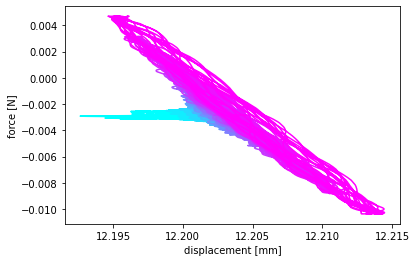

In [11]:
_ = proc_files(list_names, filter_type=1, filter_axis=1, max_num=15, anal_type='plot', anal_params={'plot_type': 'stressstrain'})

In [16]:
tlen = 3
StrainSweep_FTres = proc_files(list_names, filter_type=0, filter_axis=1, filter_name='StrainSweep_1Hz', anal_type='FT', anal_params={'nperiods':tlen})
np.savetxt(os.path.join(froot, 'StrainSweep_FTres_T' + str(tlen).zfill(2) + '.dat'), StrainSweep_FTres, delimiter='\t', 
            header='time\tamplitude\tperiod\toffset\tF_abs\tF_phase\tx_abs\tx_phase\tk_abs\tk_phase\tk_real\tk_imag\tF_avg\tOSR_period\tOSR_amp')
StressSweep_FTres = proc_files(list_names, filter_type=1, filter_axis=1, anal_type='FT', anal_params={'nperiods':tlen})
np.savetxt(os.path.join(froot, 'StressSweep_FTres_T' + str(tlen).zfill(2) + '.dat'), StressSweep_FTres, delimiter='\t', 
            header='time\tamplitude\tperiod\toffset\tF_abs\tF_phase\tx_abs\tx_phase\tk_abs\tk_phase\tk_real\tk_imag\tF_avg\tOSR_period\tOSR_amp')

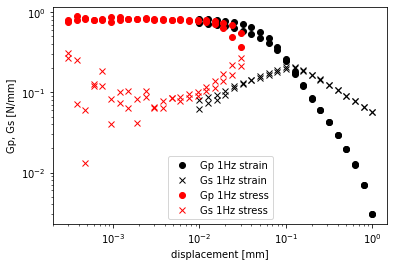

In [18]:
fig, ax = plt.subplots()
ax.plot(StrainSweep_FTres[:,1], StrainSweep_FTres[:,10], 'ko', label='Gp 1Hz strain')
ax.plot(StrainSweep_FTres[:,1], StrainSweep_FTres[:,11], 'kx', label='Gs 1Hz strain')
ax.plot(StressSweep_FTres[:,1], StressSweep_FTres[:,10], 'ro', label='Gp 1Hz stress')
ax.plot(StressSweep_FTres[:,1], StressSweep_FTres[:,11], 'rx', label='Gs 1Hz stress')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('displacement [mm]')
ax.set_ylabel('Gp, Gs [N/mm]')
ax.legend()

In [3]:
froot = r'D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\06_Creep'
rheo_protocol = rconf.RheoProtocol(froot, 'Config_Rheo.ini', 'expLog.txt')
print(rheo_protocol)

INFO:root:1351 rows read from expLog file D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\06_Creep\expLog.txt


<RheoProtocol (108 intervals)>


In [4]:
list_names = rheo_protocol.GetFullFilenames()
#list_names

In [5]:
rheo_explog = rheo_protocol.LoadExpLog()
rheo_explog

,ID,Time,Type,Name,Force,Displacement,Speed,Period,Offset,RelOffset,...,StartedOn,EndedOn,StartPos,EndPos,StartForce,EndForce,Trigger,Active,Axis,StrainControlled
0,1,3.32237,0,01_Relax_000,<err>,1,6.28319,1,0,1,...,0.021196,3.29146,11.9995,11.9995,-0.00174566,0.0162313,0,1,1,1
1,2,6.62881,0,01_Relax_001,<err>,0.794328,4.99091,1,0,1,...,3.3438,6.59652,11.9994,11.9994,0.013596,0.0119343,0,1,1,1
2,3,10.0091,0,01_Relax_002,<err>,0.630957,3.96442,1,0,1,...,6.64849,9.97892,11.9994,11.9994,0.0103229,0.0083758,0,1,1,1
3,4,13.3279,0,01_Relax_003,<err>,0.501187,3.14905,1,0,1,...,10.0291,13.2954,11.9994,11.9994,0.00676443,0.00379345,0,1,1,1
4,5,16.6081,0,01_Relax_004,<err>,0.398107,2.50138,1,0,1,...,13.3545,16.5783,11.9994,11.9994,0.00204779,-0.00120853,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,21,3351.51,0,107_Relax_020,<err>,0.01,0.0628319,1,0,1,...,3348.3,3351.48,11.999,11.999,0.00164495,0.00161138,0,1,1,1
1346,109,3461.82,3,108_SoftCreep1_0.05_0000,0.05,<err>,<err>,100,0,1,...,3351.54,3461.66,11.999,13.0262,0.000553911,-0.002266,0,1,1,0
1347,109,3572.05,3,108_SoftCreep1_0.05_0000,0.05,<err>,<err>,100,0,1,...,3461.83,3571.9,11.999,11.1444,0.0224754,-0.00402844,0,1,1,0
1348,109,3682.29,3,108_SoftCreep1_0.05_0001,0.05,<err>,<err>,100,0,1,...,3572.07,3682.14,11.999,12.9879,-0.0156606,-0.00367595,0,1,1,0


D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\06_Creep\02_Creep_0.015_0001_POS.txt


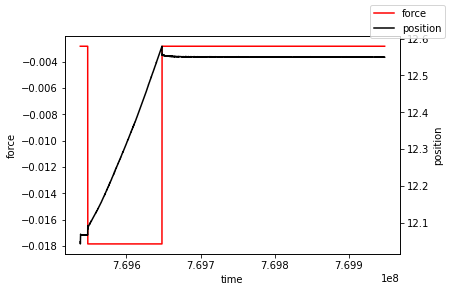

In [6]:
fidx = 23
print(list_names[fidx])
int_time, int_pos, int_force = iof.ReadRheoData(list_names[fidx], usecols=(1, 5, 6), unpack=True)
if int_pos is not None:
    fig, ax = plt.subplots()
    ax.plot(int_time, int_force, 'r-', label='force')
    ax.set_xlabel('time')
    ax.set_ylabel('force')
    ax2 = ax.twinx()
    ax2.plot(int_time, int_pos, 'k-', label='position')
    ax2.set_ylabel('position')
    fig.legend()


C:\Users\steaime\miniconda3\envs\DSH\lib\site-packages\ipykernel_launcher.py:186: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
C:\Users\steaime\miniconda3\envs\DSH\lib\site-packages\ipykernel_launcher.py:186: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


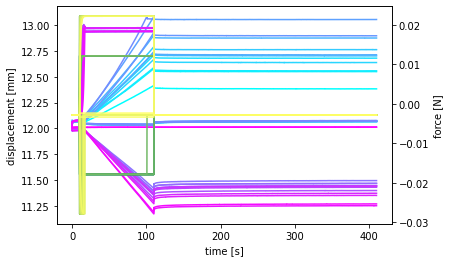

In [25]:
_ = proc_files(list_names, filter_type=3, filter_axis=1, max_num=50, anal_type='plot', anal_params={'plot_type': 'time'})

In [7]:
rheo_explog[(rheo_explog['Type'] == '3') & (rheo_explog['Axis'] == '1')]

,ID,Time,Type,Name,Force,Displacement,Speed,Period,Offset,RelOffset,...,StartedOn,EndedOn,StartPos,EndPos,StartForce,EndForce,Trigger,Active,Axis,StrainControlled
21,3,479.104,3,02_Creep_0.015_0000,0.015,<err>,<err>,100,0,1,...,68.8307,478.961,11.9994,12.3831,0.00218207,-0.00219886,0,1,1,0
22,3,889.353,3,02_Creep_0.015_0000,0.015,<err>,<err>,100,0,1,...,479.124,889.252,11.9994,12.0672,0.0208472,-0.0023835,0,1,1,0
23,3,1299.65,3,02_Creep_0.015_0001,0.015,<err>,<err>,100,0,1,...,889.368,1299.5,11.9994,12.5498,0.0405698,-0.00280313,0,1,1,0
24,3,1709.89,3,02_Creep_0.015_0001,0.015,<err>,<err>,100,0,1,...,1299.68,1709.79,11.9993,12.0689,0.0196051,-0.00258492,0,1,1,0
46,5,2189.04,3,04_SoftCreep0.01_0.015_0000,0.015,<err>,<err>,100,0,1,...,1778.76,2188.89,11.9994,12.5576,0.00322275,-0.00276955,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,107,3282.78,3,106_SoftCreep0.5_0.05_0001,0.05,<err>,<err>,100,0,1,...,3172.54,3282.64,11.999,11.1412,0.0211493,-0.00312204,0,1,1,0
1346,109,3461.82,3,108_SoftCreep1_0.05_0000,0.05,<err>,<err>,100,0,1,...,3351.54,3461.66,11.999,13.0262,0.000553911,-0.002266,0,1,1,0
1347,109,3572.05,3,108_SoftCreep1_0.05_0000,0.05,<err>,<err>,100,0,1,...,3461.83,3571.9,11.999,11.1444,0.0224754,-0.00402844,0,1,1,0
1348,109,3682.29,3,108_SoftCreep1_0.05_0001,0.05,<err>,<err>,100,0,1,...,3572.07,3682.14,11.999,12.9879,-0.0156606,-0.00367595,0,1,1,0


In [24]:
proc_files(list_names, filter_type=3, filter_axis=1, rep_len=1, anal_type='count')

216

In [11]:
creep_intlist = rheo_protocol.FilterIntervals({'type':'STEP_FORCE', 'axID':1})
creep_fnames = rconf.GetIntervalFilenames(creep_intlist, rheo_protocol.config_folder)
creep_data = proc_files(creep_fnames, anal_type='read')  

In [20]:
max_len = np.max([len(x[0]) for x in creep_data])
creep_res_comb = np.ones((max_len, 1+2*len(creep_data)), dtype=float) * np.nan
creep_res_comb[:,0] = (creep_data[0][0]-creep_data[0][0][0])/1000-creep_intlist[0].steptime
step_tidx = max(0, bisect.bisect(creep_res_comb[:,0], 0) - 1)
creep_hdr = 't-tstep[s]'
for i in range(len(creep_data)):
    if creep_fnames[i][-7:-4]=='POS':
        f_sign = 1
    else:
        f_sign = -1
    creep_res_comb[:len(creep_data[i][2]),2*i+1] = -f_sign*(creep_data[i][2]-creep_data[i][2][step_tidx])*2/9.75e-4
    creep_res_comb[:len(creep_data[i][1]),2*i+2] = f_sign*(creep_data[i][1]-creep_data[i][1][step_tidx])/0.38
    creep_hdr += '\tstress{0}\tstrain{0}'.format(i)

np.savetxt(os.path.join(froot, 'CreepCombined.dat'), creep_res_comb, delimiter='\t', header=creep_hdr)